In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import sklearn
import math

# Aux data preparation functions

In [2]:
def parse_emotion(emotion,emo_dict):
    return emo_dict[emotion]
def process_pixels(pixel_str):
    pixel_lst=[int(px) for px in pixel_str.split()]
    return pixel_lst
def show_some_emotion(df,num=[3,5]):
    faces=np.random.choice(range(len(df)),size=num[0]*num[1],replace=False)
    fig,axes=plt.subplots(num[0],num[1],figsize=(num[1]*2.5,num[0]*2.5))
    for i in range(num[0]):
        for j in range(num[1]):
            face=faces[i*num[1]+j]
            axes[i][j].imshow(np.array(df['pixels'].iloc[face]).reshape(48,48),cmap='gray')
            axes[i][j].set_title(df['emotion'].iloc[face])
    plt.tight_layout()
    plt.show()
def filter_emotions(df,keep_emotions):
    return df[df['emotion'].isin(keep_emotions)]
def equalize_groups(df,label):
    largest_group=df.groupby(label).count().max()[0]
    upscaled_groups=[]
    for _,group in df.groupby(label):
        group_ratio=int(round(1.0*largest_group/len(group)))
        upscaled_groups.extend([group]*group_ratio)
    return pd.concat(upscaled_groups,axis=0,ignore_index=True)
def normalize_pixels(pixel_lst,factor=255):
    if factor=='norm':
        px_avg=np.mean(pixel_lst)
        px_std=np.std(pixel_lst)
        pixel_lst=[(1.0*px-px_avg)/px_std for px in pixel_lst]
    elif factor=='max':
        px_max=np.max(pixel_lst)
        pixel_lst=[1.0*px/px_max for px in pixel_lst]
    else:
        pixel_lst=[1.0*px/factor for px in pixel_lst]
    return pixel_lst
def prepare_data(faces_file,emo_dict,
                 emo_filter=False,
                 equalize=True,
                 sample=False,random_state=None,
                 plot_sample=[3,5],
                 normalize=255):
    df=pd.read_csv(faces_file,usecols=[0,1])
    df['emotion']=df['emotion'].map(lambda emotion: parse_emotion(emotion,emo_dict))
    if emo_filter!=False:
        df=filter_emotions(df,keep_emotions)
    if equalize:
        df=equalize_groups(df,'emotion')
    if sample:
        df=df.sample(sample,random_state=random_state)
    df['pixels']=df['pixels'].map(process_pixels)
    if plot_sample!=False:
        show_some_emotion(df,plot_sample)
    if normalize:
        df['pixels']=df['pixels'].map(lambda pixels: normalize_pixels(pixels,factor=normalize))
    X=np.array(df['pixels'].values.tolist())
    labels=list(df['emotion'].unique())
    Y=df['emotion'].map(lambda x: labels.index(x)).values
    return X,Y

# Aux NN functions

In [3]:
def one_hot_encoder(v):
    return np.eye(v.max()+1)[v]
def one_hot_decoder(v):
    return np.argmax(v,axis=1)
def sigmoid(v,derivate=False):
    if derivate:
        return v*(1-v)
    else:
        return 1/(1+np.exp(-v))
def relu(v,derivate=False):
    if derivate:
        return (v>0)
    else:
        return v*(v>0)
def tanh(v,derivate=False):
    if derivate:
        return 1-v*v
    else:
        return np.tanh(v)
def softmax(v):
    expv=np.exp(v)
    if v.shape[0]>1:
        return expv/expv.sum(axis=1,keepdims=True)
    else:
        return expv/expv.sum(axis=1)
def cross_entropy_cost(Y,P):
    return -(Y*np.log(P)).mean()
def accuracy(Y,P):
    return (Y==P).mean()
def rmse(Y,P):
    return np.sqrt(((P-Y)**2).mean())

# La classe

In [4]:
class NN_01(object):
    def __init__(self,
                 net_structure,
                 f_encode_Y=one_hot_encoder,
                 f_decode_Y=one_hot_decoder,
                 f_transfer=sigmoid,
                 f_output=lambda v: softmax(sigmoid(v)),
                 f_cost=cross_entropy_cost,
                 f_accuracy=accuracy):
        self.net_structure=net_structure
        self.f_encode_Y=f_encode_Y
        self.f_decode_Y=f_decode_Y
        self.f_transfer=f_transfer
        self.f_output=f_output
        self.f_cost=f_cost
        self.f_accuracy=f_accuracy
    def train(self,X,Y,W_0=None,
              frac_test=0.2,random_state=None,
              learning_rate=10e-7,regularization=0,num_rounds=100001,
              report_step=100,print_every=5000,print_acc=True,plot_cost=True):
        self.training_report=[]
        X,Y=sklearn.utils.shuffle(X,Y,random_state=random_state)
        num_test=int(frac_test*X.shape[0])
        X_train,Y_train=X[:-num_test],Y[:-num_test]
        X_test,Y_test=X[-num_test:],Y[-num_test:]
        eY_train,eY_test=self.f_encode_Y(Y_train),self.f_encode_Y(Y_test)
        if W_0!=None:
            self.W=W_0
        else:
            self.W=self.populate_W(X_train,eY_train)
        peY_train,peY_test=self.feed_forward(X_train),self.feed_forward(X_test)
        global_start=datetime.datetime.now()
        reporting_start=datetime.datetime.now()
        for n in range(num_rounds):
            delta=peY_train[-1]-eY_train
            for l in reversed(range(len(self.W))):
                gradient,new_delta=self.derivate_layer(self.W[l],peY_train[l],delta)
                delta=new_delta
                self.W[l]=self.W[l]*(1-learning_rate*regularization)-learning_rate*gradient
            peY_train,peY_test=self.feed_forward(X_train),self.feed_forward(X_test)
            if n % report_step==0:
                c_train,c_test=self.f_cost(eY_train,peY_train[-1]),self.f_cost(eY_test,peY_test[-1])
                pY_train,pY_test=self.f_decode_Y(peY_train[-1]),self.f_decode_Y(peY_test[-1])
                acc_train,acc_test=self.f_accuracy(Y_train,pY_train),self.f_accuracy(Y_test,pY_test)
                global_duration=(datetime.datetime.now()-global_start).total_seconds()
                if print_every and n % print_every==0:
                    global_left=global_duration*(num_rounds-n+1)/(n+1)
                    reporting_duration=(datetime.datetime.now()-reporting_start).total_seconds()
                    reporting_start=datetime.datetime.now()
                    print('{:5d} '.format(n)),
                    print('{:0.5f} {:0.5f} '.format(acc_train,acc_test)),
                    print('{:0.5f} {:0.5f} '.format(c_train,c_test)),
                    print('{:7.2f} {:7.2f}  {:7.2f}'.format(reporting_duration,global_duration,global_left))
                self.training_report.append([n,acc_train,acc_test,c_train,c_test,global_duration])
        if plot_cost:
            plt.plot([r[3] for r in self.training_report])
            plt.plot([r[4] for r in self.training_report])
            plt.show()
    def populate_W(self,X,T):
        net_structure=[X[0].size]+self.net_structure+[T[0].size]
        W=[]
        for i in range(len(net_structure)-1):
            nodes_this=net_structure[i]+1
            nodes_next=net_structure[i+1]
            W.append(np.random.randn(nodes_this,nodes_next)/np.sqrt(nodes_this+nodes_next))
        return W
    def derivate_layer(self,W_layer,layer,delta):
        next_delta=delta.dot(W_layer[:-1,:].T)*self.f_transfer(layer,derivate=True)
        layer=np.append(layer,np.ones((layer.shape[0],1)),1)
        return layer.T.dot(delta),next_delta
    def predict(self,X):
        return self.f_decode_Y(self.feed_forward(X))
    def feed_forward(self,X):
        v=[X]
        for l in range(len(self.W)-1):
            v.append(self.f_transfer(self.process_layer(v[-1],self.W[l])))
        v.append(self.f_output(self.process_layer(v[-1],self.W[-1])))
        return v
    def process_layer(self,X,W):
        X=np.append(X,np.ones((X.shape[0],1)),1)
        return X.dot(W)

# Data preparation

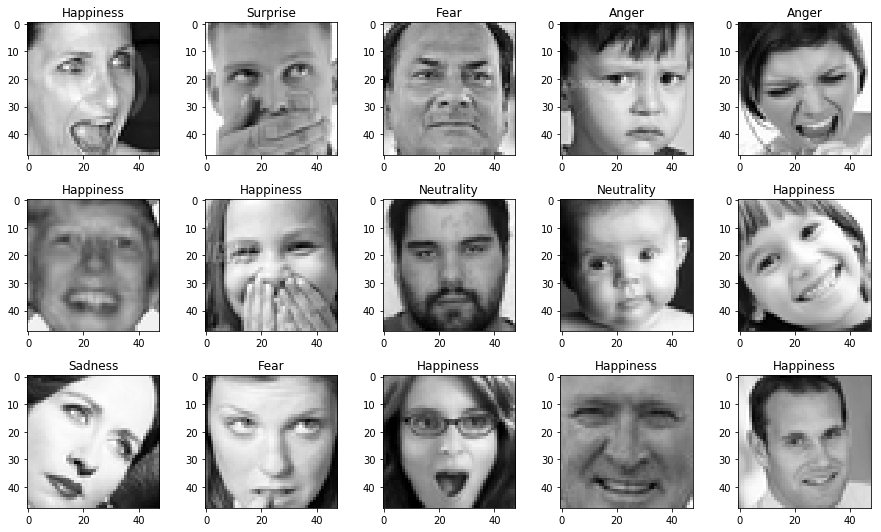

((3500, 2304), (3500,))

In [5]:
file_name='data/fer2013.csv.bz2'
emo_dict={0:'Anger',1:'Disgust',2:'Fear',3:'Happiness',4:'Sadness',5:'Surprise',6:'Neutrality'}
X,Y=prepare_data(file_name,emo_dict,
                 emo_filter=False,
                 equalize=True,
                 sample=3500,random_state=None,
                 plot_sample=[3,5],
                 normalize=255)
X.shape,Y.shape

# Multi class classifier, 16 nodes

## Sigmoid

In [14]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.16536 0.13143  0.27642 0.27687     0.22    0.22  1082.38
  500  0.20321 0.19286  0.27316 0.27396    99.13   99.34   892.72
 1000  0.23429 0.21000  0.27063 0.27203    99.23  198.57   793.89
 1500  0.26321 0.24714  0.26763 0.26974    98.90  297.47   694.03
 2000  0.29929 0.27286  0.26446 0.26734   100.28  397.75   596.72
 2500  0.32357 0.29714  0.26158 0.26526    97.39  495.14   495.33
 3000  0.33321 0.30714  0.25917 0.26366    97.29  592.43   395.22
 3500  0.34500 0.31143  0.25718 0.26250    97.76  690.19   296.11
 4000  0.34786 0.31714  0.25549 0.26163    97.72  787.91   197.32
 4500  0.34893 0.32143  0.25400 0.26095    97.53  885.44    98.75
 5000  0.35357 0.32714  0.25265 0.26038    98.25  983.70     0.39


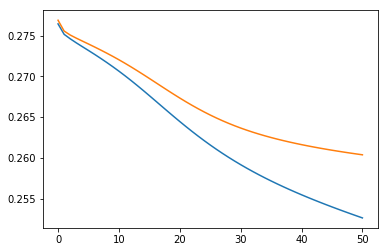

CPU times: user 37min 14s, sys: 27min 34s, total: 1h 4min 49s
Wall time: 16min 23s


In [16]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0.1,num_rounds=5001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Relu

In [9]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=relu,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.14143 0.16429  0.27903 0.27987     0.19    0.19   969.88
  500  0.19357 0.21286  0.27411 0.27226    86.16   86.36   776.00
 1000  0.20107 0.20571  0.27268 0.27105    86.15  172.50   689.67
 1500  0.21679 0.20857  0.27131 0.26998    85.96  258.46   603.03
 2000  0.22357 0.22429  0.27003 0.26898    88.73  347.20   520.88
 2500  0.23321 0.22857  0.26880 0.26801    85.35  432.55   432.72
 3000  0.23929 0.23429  0.26766 0.26713    85.33  517.88   345.48
 3500  0.24714 0.24143  0.26661 0.26636    85.45  603.33   258.84
 4000  0.25357 0.25571  0.26563 0.26568    84.28  687.61   172.20
 4500  0.25964 0.25429  0.26477 0.26517   103.14  790.74    88.19
 5000  0.26750 0.26571  0.26404 0.26481   136.60  927.35     0.37


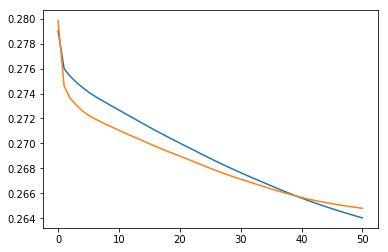

CPU times: user 36min 6s, sys: 22min 26s, total: 58min 32s
Wall time: 15min 27s


In [11]:
%%time
my_NN.train(X,Y,learning_rate=10e-7,regularization=0.1,num_rounds=5001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Tanh

In [12]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=tanh,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.14643 0.16857  0.28033 0.27841     0.25    0.25  1241.17
  500  0.20321 0.19429  0.27340 0.27461   153.31  153.56  1379.88
 1000  0.22679 0.21000  0.27172 0.27315   156.56  310.12  1239.87
 1500  0.25107 0.23286  0.27024 0.27194   161.31  471.43  1099.91
 2000  0.26357 0.24429  0.26878 0.27082   160.31  631.75   947.78
 2500  0.27214 0.24857  0.26731 0.26974   129.05  760.80   761.10
 3000  0.28857 0.25286  0.26582 0.26871   151.14  911.94   608.36
 3500  0.29536 0.26571  0.26435 0.26774   126.45 1038.38   445.49
 4000  0.30857 0.27714  0.26293 0.26684   109.26 1147.64   287.41
 4500  0.31714 0.27857  0.26158 0.26602   119.71 1267.35   141.35
 5000  0.32964 0.28429  0.26033 0.26529   104.21 1371.57     0.55


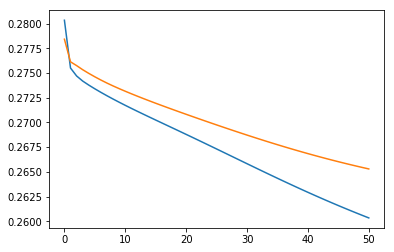

CPU times: user 37min 41s, sys: 34min 12s, total: 1h 11min 53s
Wall time: 22min 52s


In [13]:
%%time
my_NN.train(X,Y,learning_rate=10e-7,regularization=0.1,num_rounds=5001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

# Multi class classifier, 32 nodes

## Sigmoid

In [12]:
my_NN=NN_01(net_structure=[32],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.18857 0.16714  0.27783 0.27826     0.22    0.22  2167.90
  500  0.20036 0.17429  0.27221 0.27533   103.02  103.24  1957.99
 1000  0.21143 0.19143  0.26955 0.27343   105.32  208.56  1875.57
 1500  0.24179 0.21286  0.26624 0.27112   119.52  328.08  1858.29
 2000  0.27964 0.26429  0.26270 0.26875   110.75  438.82  1754.85
 2500  0.31286 0.28143  0.25952 0.26681   113.14  551.96  1655.65
 3000  0.34071 0.30000  0.25694 0.26545   104.66  656.62  1532.04
 3500  0.35607 0.30571  0.25490 0.26457   104.06  760.68  1412.72
 4000  0.36750 0.31571  0.25324 0.26399   106.43  867.11  1300.77
 4500  0.37143 0.32000  0.25181 0.26358   102.54  969.64  1185.29
 5000  0.37679 0.32286  0.25052 0.26329   102.35 1071.99  1072.21
 5500  0.37821 0.32429  0.24934 0.26311   102.63 1174.63   961.31
 6000  0.38643 0.32429  0.24824 0.26301   102.26 1276.89   851.54
 6500  0.39143 0.32000  0.24721 0.26299   103.00 1379.89   743.33
 7000  0.40000 0.32286  0.24624 0.26302   102.40 1482.28   635.60
 7500  0.4

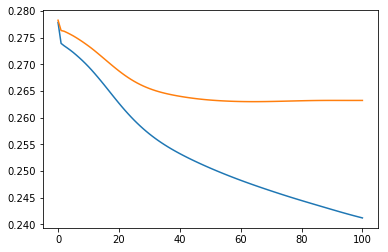

CPU times: user 1h 20min 7s, sys: 57min 7s, total: 2h 17min 15s
Wall time: 35min 15s


In [14]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0.1,num_rounds=10001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Relu

In [7]:
my_NN=NN_01(net_structure=[32],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=relu,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.14679 0.15286  0.27741 0.27791     0.21    0.21  2071.72
  500  0.19321 0.19571  0.27364 0.27368    93.94   94.15  1785.67
 1000  0.21571 0.20286  0.27173 0.27233    85.71  179.86  1617.51
 1500  0.23750 0.23571  0.26997 0.27119    85.67  265.54  1504.06
 2000  0.24857 0.24714  0.26827 0.27012    86.20  351.73  1406.58
 2500  0.26500 0.24429  0.26670 0.26913    85.14  436.88  1310.46
 3000  0.27500 0.25000  0.26518 0.26826    85.64  522.51  1219.14
 3500  0.28179 0.24857  0.26387 0.26759    85.95  608.46  1130.02
 4000  0.28679 0.25143  0.26270 0.26710    85.57  694.03  1041.13
 4500  0.29143 0.25714  0.26168 0.26672    85.89  779.92   953.37
 5000  0.29250 0.25143  0.26082 0.26651    85.96  865.88   866.05
 5500  0.30036 0.25714  0.26009 0.26645    86.34  952.22   779.29
 6000  0.30286 0.25857  0.25947 0.26651    85.28 1037.50   691.90
 6500  0.30321 0.24714  0.25895 0.26666    85.75 1123.25   605.08
 7000  0.30357 0.24429  0.25853 0.26684    86.85 1210.10   518.89
 7500  0.3

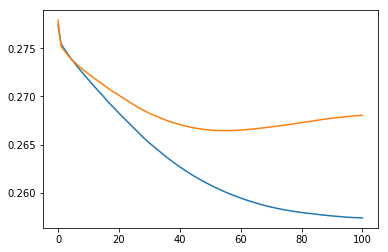

CPU times: user 1h 14min 32s, sys: 39min 34s, total: 1h 54min 6s
Wall time: 28min 45s


In [8]:
%%time
my_NN.train(X,Y,learning_rate=10e-7,regularization=0.1,num_rounds=10001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Tanh

In [9]:
my_NN=NN_01(net_structure=[32],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=tanh,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.12643 0.14143  0.27896 0.27919     0.21    0.21  2100.64
  500  0.19214 0.18429  0.27351 0.27320    99.90  100.11  1898.62
 1000  0.22464 0.21571  0.27135 0.27144    99.47  199.58  1794.80
 1500  0.25321 0.22857  0.26956 0.27010    99.25  298.83  1692.65
 2000  0.27821 0.23714  0.26796 0.26900    99.76  398.59  1593.97
 2500  0.29143 0.25000  0.26644 0.26802    99.52  498.11  1494.13
 3000  0.30357 0.25000  0.26497 0.26713    99.51  597.62  1394.39
 3500  0.31500 0.25714  0.26354 0.26631    99.89  697.51  1295.41
 4000  0.32500 0.26571  0.26216 0.26554    99.51  797.02  1195.64
 4500  0.33393 0.27429  0.26084 0.26484    99.02  896.04  1095.31
 5000  0.33679 0.27429  0.25960 0.26421   100.20  996.24   996.44
 5500  0.33821 0.27571  0.25843 0.26365    99.70 1095.94   896.92
 6000  0.34500 0.26857  0.25734 0.26316    99.61 1195.55   797.30
 6500  0.35214 0.27143  0.25634 0.26274    99.71 1295.26   697.74
 7000  0.35714 0.26857  0.25541 0.26239    99.53 1394.78   598.08
 7500  0.3

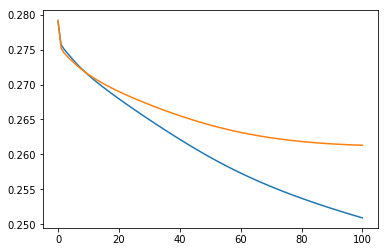

CPU times: user 1h 20min 21s, sys: 51min 57s, total: 2h 12min 19s
Wall time: 33min 12s


In [10]:
%%time
my_NN.train(X,Y,learning_rate=10e-7,regularization=0.1,num_rounds=10001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

# Multi class classifier, 16 + 16 nodes

## Sigmoid

In [13]:
my_NN=NN_01(net_structure=[16,16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.13679 0.15143  0.27962 0.27920     0.21    0.21  2084.47
  500  0.18786 0.19000  0.27466 0.27427   102.51  102.72  1948.23
 1000  0.21750 0.21571  0.26846 0.27096   102.16  204.88  1842.52
 1500  0.26429 0.24857  0.26259 0.26653   102.00  306.89  1738.28
 2000  0.27286 0.26143  0.26497 0.26732   100.20  407.09  1627.95
 2500  0.29643 0.26143  0.25860 0.26446   100.87  507.96  1523.69
 3000  0.26393 0.25429  0.26330 0.26845   101.34  609.30  1421.63
 3500  0.32679 0.27429  0.25676 0.26297   100.58  709.88  1318.38
 4000  0.29500 0.25286  0.26238 0.26963   100.68  810.56  1215.94
 4500  0.28786 0.26857  0.26011 0.26668   102.95  913.51  1116.67
 5000  0.22750 0.22143  0.26929 0.27109   100.31 1013.82  1014.02
 5500  0.32607 0.26571  0.25980 0.26417    99.49 1113.31   911.13
 6000  0.29679 0.24286  0.25852 0.26706   100.84 1214.15   809.70
 6500  0.31607 0.24286  0.25661 0.26726    99.58 1313.73   707.69
 7000  0.27857 0.22714  0.26574 0.27127   101.24 1414.98   606.74
 7500  0.2

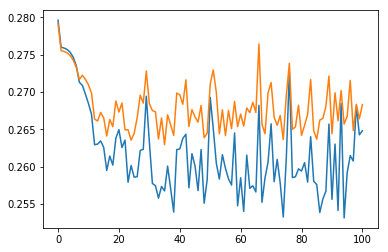

CPU times: user 1h 16min 28s, sys: 56min 11s, total: 2h 12min 40s
Wall time: 33min 39s


In [14]:
%%time
my_NN.train(X,Y,learning_rate=10e-5,regularization=0.1,num_rounds=10001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Relu

In [15]:
my_NN=NN_01(net_structure=[16,16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=relu,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.16821 0.16000  0.27725 0.27749     0.17    0.17  1689.93
  500  0.18000 0.17286  0.27592 0.27635    82.74   82.91  1572.53
 1000  0.18000 0.17286  0.27536 0.27595    81.97  164.88  1482.80
 1500  0.18036 0.17286  0.27483 0.27556    82.20  247.09  1399.56
 2000  0.18536 0.17571  0.27433 0.27510    82.25  329.34  1317.03
 2500  0.18500 0.17571  0.27386 0.27468    82.41  411.75  1235.09
 3000  0.19429 0.18571  0.27338 0.27423    82.15  493.90  1152.39
 3500  0.20500 0.18429  0.27287 0.27376    82.24  576.14  1070.00
 4000  0.21179 0.17714  0.27231 0.27327    82.90  659.04   988.65
 4500  0.21500 0.19571  0.27169 0.27275    81.90  740.94   905.73
 5000  0.21786 0.20000  0.27099 0.27214    82.46  823.40   823.57
 5500  0.22321 0.20571  0.27022 0.27152    82.69  906.09   741.54
 6000  0.22786 0.21429  0.26946 0.27093    82.90  988.99   659.55
 6500  0.23107 0.21571  0.26864 0.27029    82.58 1071.57   577.24
 7000  0.23714 0.21857  0.26769 0.26958    82.57 1154.14   494.89
 7500  0.2

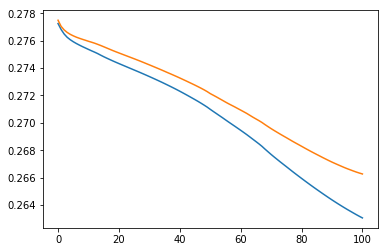

CPU times: user 1h 10min 59s, sys: 38min 31s, total: 1h 49min 30s
Wall time: 27min 30s


In [19]:
%%time
my_NN.train(X,Y,learning_rate=5*10e-8,regularization=0.1,num_rounds=10001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Tanh

In [20]:
my_NN=NN_01(net_structure=[16,16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=tanh,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.13786 0.14000  0.27847 0.27841     0.20    0.20  1976.17
  500  0.19071 0.16571  0.27642 0.27626    96.12   96.32  1826.76
 1000  0.19500 0.17429  0.27594 0.27584    96.00  192.32  1729.50
 1500  0.19607 0.17571  0.27556 0.27553    95.84  288.16  1632.20
 2000  0.20071 0.17714  0.27519 0.27524    95.90  384.06  1535.87
 2500  0.20607 0.18000  0.27480 0.27494    95.68  479.74  1439.04
 3000  0.21000 0.18143  0.27440 0.27464    95.69  575.43  1342.61
 3500  0.21357 0.19286  0.27400 0.27433    95.89  671.32  1246.76
 4000  0.21893 0.19429  0.27359 0.27402    96.53  767.85  1151.87
 4500  0.22500 0.19000  0.27318 0.27370    96.34  864.19  1056.38
 5000  0.23036 0.20429  0.27276 0.27337    96.22  960.40   960.59
 5500  0.23571 0.21143  0.27234 0.27304    96.59 1056.99   865.04
 6000  0.24107 0.21286  0.27190 0.27269    96.02 1153.00   768.93
 6500  0.24536 0.21000  0.27144 0.27234    96.45 1249.45   673.06
 7000  0.24679 0.22286  0.27095 0.27196    95.82 1345.27   576.85
 7500  0.2

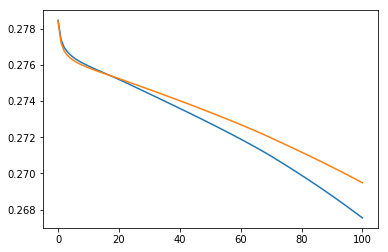

CPU times: user 1h 15min 33s, sys: 52min 2s, total: 2h 7min 36s
Wall time: 32min 2s


In [21]:
%%time
my_NN.train(X,Y,learning_rate=5*10e-8,regularization=0.1,num_rounds=10001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

# Multi class classifier, 32 + 32 nodes

## Sigmoid

In [22]:
my_NN=NN_01(net_structure=[32,32],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.11107 0.08429  0.27884 0.27954     0.24    0.24  2403.85
  500  0.18071 0.19286  0.27525 0.27450   107.44  107.68  2042.34
 1000  0.23250 0.20714  0.26999 0.27103   106.78  214.46  1928.68
 1500  0.25393 0.22000  0.26616 0.26863   106.81  321.27  1819.77
 2000  0.27179 0.24429  0.26212 0.26668   109.32  430.59  1721.95
 2500  0.33321 0.26286  0.25530 0.26683   107.00  537.60  1612.58
 3000  0.33107 0.26714  0.25443 0.26424   107.00  644.59  1503.98
 3500  0.33393 0.24857  0.25508 0.26795   107.00  751.59  1395.84
 4000  0.38357 0.27571  0.25023 0.26327   106.89  858.48  1287.82
 4500  0.39179 0.25429  0.24928 0.26703   107.24  965.72  1180.49
 5000  0.36214 0.27286  0.25121 0.26414   106.91 1072.63  1072.85
 5500  0.38571 0.28571  0.24784 0.26286   107.09 1179.72   965.48
 6000  0.41786 0.28000  0.24454 0.26677   107.61 1287.33   858.51
 6500  0.40964 0.27143  0.24675 0.26844   107.06 1394.39   751.14
 7000  0.36286 0.24714  0.24028 0.26330   107.19 1501.58   643.87
 7500  0.3

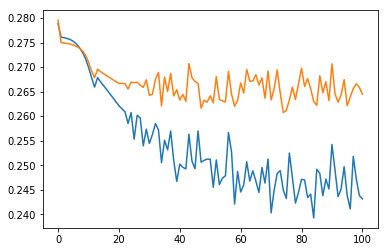

CPU times: user 1h 23min 55s, sys: 58min 21s, total: 2h 22min 17s
Wall time: 35min 52s


In [23]:
%%time
my_NN.train(X,Y,learning_rate=5*10e-6,regularization=0.1,num_rounds=10001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Relu

In [24]:
my_NN=NN_01(net_structure=[32,32],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=relu,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.11821 0.12143  0.27873 0.27887     0.18    0.18  1840.94
  500  0.14429 0.13286  0.27741 0.27807    88.07   88.25  1673.82
 1000  0.19000 0.13429  0.27640 0.27765    87.72  175.97  1582.49
 1500  0.18750 0.15286  0.27527 0.27721    87.16  263.13  1490.43
 2000  0.18571 0.14857  0.27449 0.27681    86.86  349.99  1399.63
 2500  0.18536 0.15000  0.27400 0.27647    87.29  437.29  1311.69
 3000  0.18643 0.14857  0.27362 0.27619    86.90  524.18  1223.04
 3500  0.18786 0.15000  0.27318 0.27583    87.16  611.34  1135.37
 4000  0.19357 0.14714  0.27270 0.27543    87.83  699.17  1048.85
 4500  0.19893 0.14571  0.27215 0.27497    86.67  785.84   960.61
 5000  0.21143 0.15571  0.27155 0.27446    87.00  872.84   873.01
 5500  0.21286 0.16286  0.27086 0.27387    86.78  959.62   785.35
 6000  0.22500 0.16857  0.27010 0.27324    88.34 1047.96   698.87
 6500  0.23000 0.17286  0.26928 0.27256    87.10 1135.06   611.44
 7000  0.23857 0.19000  0.26839 0.27183    87.17 1222.23   524.09
 7500  0.2

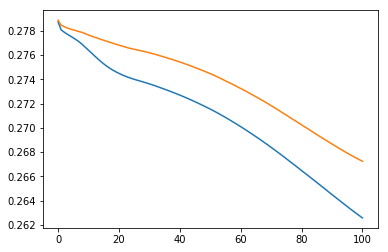

CPU times: user 1h 15min 53s, sys: 39min 57s, total: 1h 55min 50s
Wall time: 29min 5s


In [25]:
%%time
my_NN.train(X,Y,learning_rate=5*10e-8,regularization=0.1,num_rounds=10001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Tanh

In [26]:
my_NN=NN_01(net_structure=[32,32],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=tanh,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.12643 0.12571  0.27862 0.27851     0.21    0.21  2126.83
  500  0.17929 0.17857  0.27525 0.27573   103.47  103.68  1966.38
 1000  0.18179 0.17429  0.27472 0.27534   103.59  207.26  1863.93
 1500  0.18929 0.18857  0.27419 0.27493   104.17  311.44  1764.06
 2000  0.19857 0.19143  0.27367 0.27453   103.53  414.97  1659.47
 2500  0.20607 0.20143  0.27313 0.27411   103.24  518.21  1554.42
 3000  0.21036 0.20000  0.27256 0.27367   103.34  621.55  1450.22
 3500  0.22321 0.20571  0.27195 0.27318   102.92  724.48  1345.48
 4000  0.23464 0.22143  0.27128 0.27263   103.14  827.62  1241.53
 4500  0.24179 0.22143  0.27057 0.27204   103.82  931.44  1138.59
 5000  0.25821 0.22429  0.26981 0.27140   103.87 1035.31  1035.52
 5500  0.26357 0.22714  0.26901 0.27073   107.64 1142.95   935.38
 6000  0.27071 0.22571  0.26816 0.27003   108.41 1251.35   834.51
 6500  0.27643 0.22714  0.26730 0.26932   108.51 1359.86   732.54
 7000  0.29143 0.22857  0.26642 0.26861   145.44 1505.30   645.47
 7500  0.3

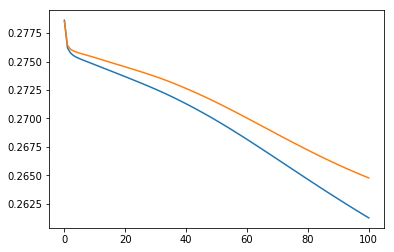

CPU times: user 1h 23min 16s, sys: 1h 34s, total: 2h 23min 51s
Wall time: 38min 36s


In [27]:
%%time
my_NN.train(X,Y,learning_rate=5*10e-8,regularization=0.1,num_rounds=10001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)